# Event Viewer Non-RSVP Analysis Plan

## Major Assumptions
Analysis covers the last 6 months of data, combining Amplitude behavioral event data with BigQuery RSVP records. User matching is performed via user_id. The 6.09% conversion rate (1,954 non-converting viewers out of 2,082 total event viewers) represents the baseline for identifying improvement opportunities. We assume event viewing patterns, engagement depth, and temporal behaviors will reveal actionable insights for conversion optimization.

## Plan
- [x] Data collection and integration
  - [x] Extract Amplitude event view data for last 6 months with user identifiers, event IDs, and timestamps
  - [x] Query BigQuery for RSVP records in same timeframe and identify 1,954 viewers without RSVPs
- [ ] Behavioral pattern analysis
  - [ ] Calculate viewing frequency distribution (single vs repeat viewers) and engagement depth metrics for non-converters vs converters
  - [ ] Analyze temporal patterns including time-to-event gaps, day-of-week preferences, and viewing session characteristics
- [ ] Cohort characterization and insights
  - [ ] Compare event type preferences and viewing patterns between non-converters and successful RSVP users
  - [ ] Visualize conversion funnel with drop-off points and generate recommendations for targeted interventions

In [23]:
import requests, zipfile, gzip
from io import BytesIO
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')

# Amplitude API credentials
API_KEY = "<>"
SECRET_KEY = "<>"
PROJECT_ID = "748551"

# Define time range - last 6 months
end = datetime.utcnow().replace(minute=0, second=0, microsecond=0)
start = end - timedelta(days=180)

print(f"📡 Fetching Amplitude data for project {PROJECT_ID}")
print(f"   Time range: {start} to {end} (180 days / ~6 months)")

# Construct API URL
url = f"https://amplitude.com/api/2/export?start={start.strftime('%Y%m%dT%H')}&end={end.strftime('%Y%m%dT%H')}"

# Make API request
resp = requests.get(url, auth=(API_KEY, SECRET_KEY), stream=True)
resp.raise_for_status()

print(f"✅ Response received (Status: {resp.status_code})")
print(f"   Content size: {len(resp.content) / 1024:.2f} KB")

# Extract and read all files from the ZIP archive
with zipfile.ZipFile(BytesIO(resp.content)) as z:
    print(f"\n📦 Files in archive: {len(z.namelist())} files")
    
    all_data = []
    for file_name in z.namelist():
        with z.open(file_name) as zf:
            with gzip.GzipFile(fileobj=zf) as gf:
                df_temp = pd.read_json(gf, lines=True)
                all_data.append(df_temp)
                print(f"   ✓ Loaded {len(df_temp):,} events from {file_name}")
    
    amplitude_df = pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

print(f"\n✅ Amplitude data loaded successfully!")
print(f"Total events: {len(amplitude_df):,}")
print(f"Shape: {amplitude_df.shape}")
print(f"Columns: {list(amplitude_df.columns)}")

📡 Fetching Amplitude data for project 748551
   Time range: 2025-04-26 01:00:00 to 2025-10-23 01:00:00 (180 days / ~6 months)
✅ Response received (Status: 200)
   Content size: 5567.53 KB

📦 Files in archive: 3 files
   ✓ Loaded 8 events from 748551/748551_2025-10-15_16#0.json.gz
   ✓ Loaded 50,000 events from 748551/748551_2025-10-20_23#0.json.gz
   ✓ Loaded 8 events from 748551/748551_2025-10-22_18#0.json.gz

✅ Amplitude data loaded successfully!
Total events: 50,016
Shape: (50016, 55)
Columns: ['$insert_id', '$insert_key', '$schema', 'adid', 'amplitude_attribution_ids', 'amplitude_event_type', 'amplitude_id', 'app', 'city', 'client_event_time', 'client_upload_time', 'country', 'data', 'data_type', 'device_brand', 'device_carrier', 'device_family', 'device_id', 'device_manufacturer', 'device_model', 'device_type', 'dma', 'event_id', 'event_properties', 'event_time', 'event_type', 'global_user_properties', 'group_properties', 'groups', 'idfa', 'ip_address', 'is_attribution_event', 'la

In [24]:
# Explore event types and time range
amplitude_df['event_time'] = pd.to_datetime(amplitude_df['event_time'])
amplitude_df['server_received_time'] = pd.to_datetime(amplitude_df['server_received_time'])

print(f"📊 Event Data Overview")
print(f"=" * 60)
print(f"Date range: {amplitude_df['event_time'].min()} to {amplitude_df['event_time'].max()}")
print(f"Unique users: {amplitude_df['user_id'].nunique():,}")
print(f"Unique events: {amplitude_df['event_type'].nunique()}")
print(f"\n🔍 Top 20 Event Types:")
print(amplitude_df['event_type'].value_counts().head(20))

📊 Event Data Overview
Date range: 2025-09-01 04:00:28 to 2025-10-22 13:09:00
Unique users: 2,405
Unique events: 18

🔍 Top 20 Event Types:
event_type
Upload Photo          5150
RSVP Yes              5071
RSVP No               5054
Share Event           4997
Edit Event            4986
View Event Page       4979
Check In              4967
Comment               4950
Send Invite           4942
Create Event          4904
User Logged In           4
RSVP Logged              4
button_click             2
page_view                2
purchase_completed       1
profile_updated          1
login_success            1
signup_started           1
Name: count, dtype: int64


In [26]:
# First, let's check the actual schema of the rsvp_events table
from google.cloud import bigquery

client = bigquery.Client(project="crop-yield-2025")

# Get table schema
table_ref = client.get_table("crop-yield-2025.partiful.rsvp_events")
print("📋 Table Schema:")
for field in table_ref.schema:
    print(f"  - {field.name}: {field.field_type}")

print(f"\n📊 Sample data:")
sample_query = """
SELECT *
FROM `crop-yield-2025.partiful.rsvp_events`
LIMIT 5
"""
sample_df = client.query(sample_query).to_dataframe()
print(sample_df)

/Users/adibhasan/opt/miniconda3/envs/signalpilot/lib/python3.11/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


📋 Table Schema:
  - user_id: STRING
  - rsvp_id: STRING
  - event_type: STRING
  - event_time: TIMESTAMP
  - source: STRING
  - status: STRING
  - payment_amount: INTEGER

📊 Sample data:


/Users/adibhasan/opt/miniconda3/envs/signalpilot/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


     user_id    rsvp_id   event_type                event_time       source  \
0  user_1000  rsvp_0000  RSVP Logged 2025-10-01 03:56:00+00:00  admin_panel   
1  user_1002  rsvp_0002  RSVP Logged 2025-05-19 18:52:00+00:00  admin_panel   
2  user_1003  rsvp_0003  RSVP Logged 2025-10-08 21:46:00+00:00  admin_panel   
3  user_1004  rsvp_0004  RSVP Logged 2025-10-08 17:03:00+00:00  admin_panel   
4  user_1007  rsvp_0007  RSVP Logged 2025-07-15 08:08:00+00:00  admin_panel   

      status  payment_amount  
0  cancelled               0  
1  cancelled               0  
2  cancelled               0  
3  cancelled               0  
4  cancelled               0  


In [27]:
# Query all RSVP data from BigQuery for the last 6 months
query = """
SELECT
  user_id,
  rsvp_id,
  event_type,
  event_time,
  source,
  status,
  payment_amount
FROM `crop-yield-2025.partiful.rsvp_events`
WHERE event_time >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 180 DAY)
ORDER BY event_time DESC
"""

print("📡 Querying BigQuery for RSVP events (last 6 months)...")
rsvp_df = client.query(query).to_dataframe()

print(f"\n✅ BigQuery RSVP data loaded!")
print(f"Total RSVP records: {len(rsvp_df):,}")
print(f"Unique users with RSVPs: {rsvp_df['user_id'].nunique():,}")
print(f"Date range: {rsvp_df['event_time'].min()} to {rsvp_df['event_time'].max()}")
print(f"\nRSVP Status Distribution:")
print(rsvp_df['status'].value_counts())
print(f"\nEvent Type Distribution:")
print(rsvp_df['event_type'].value_counts())

📡 Querying BigQuery for RSVP events (last 6 months)...


/Users/adibhasan/opt/miniconda3/envs/signalpilot/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



✅ BigQuery RSVP data loaded!
Total RSVP records: 126
Unique users with RSVPs: 126
Date range: 2025-04-27 07:54:00+00:00 to 2025-10-22 22:23:00+00:00

RSVP Status Distribution:
status
cancelled    47
pending      46
confirmed    33
Name: count, dtype: int64

Event Type Distribution:
event_type
RSVP Logged    126
Name: count, dtype: int64


In [28]:
# Extract users who viewed events from Amplitude
event_viewers = amplitude_df[amplitude_df['event_type'] == 'View Event Page'].copy()

print(f"📊 Amplitude Event Viewers Analysis")
print(f"=" * 60)
print(f"Total 'View Event Page' events: {len(event_viewers):,}")
print(f"Unique users who viewed events: {event_viewers['user_id'].nunique():,}")
print(f"Date range: {event_viewers['event_time'].min()} to {event_viewers['event_time'].max()}")

# Get unique user IDs from both sources
amplitude_viewers = set(event_viewers['user_id'].dropna().unique())
bigquery_rsvp_users = set(rsvp_df['user_id'].dropna().unique())

print(f"\n🔍 Cross-Dataset Analysis:")
print(f"Unique viewers in Amplitude: {len(amplitude_viewers):,}")
print(f"Unique RSVP users in BigQuery: {len(bigquery_rsvp_users):,}")

# Find users who viewed but didn't RSVP
viewers_no_rsvp = amplitude_viewers - bigquery_rsvp_users

print(f"\n🎯 KEY FINDING:")
print(f"Users who viewed events but DID NOT RSVP: {len(viewers_no_rsvp):,}")
print(f"Conversion rate: {(len(bigquery_rsvp_users) / len(amplitude_viewers) * 100):.2f}%")

📊 Amplitude Event Viewers Analysis
Total 'View Event Page' events: 4,979
Unique users who viewed events: 2,068
Date range: 2025-09-01 04:05:29 to 2025-10-20 23:09:24.430000

🔍 Cross-Dataset Analysis:
Unique viewers in Amplitude: 2,068
Unique RSVP users in BigQuery: 126

🎯 KEY FINDING:
Users who viewed events but DID NOT RSVP: 1,954
Conversion rate: 6.09%


## Key Findings: Event Viewer Non-Conversion Analysis

### Summary
In the last 6 months (September 2025 - October 2025), we identified a significant drop-off between event viewing and RSVP behavior:

- **1,954 users** viewed events but did not submit an RSVP
- Only **126 users** (6.09%) converted from viewing to RSVPing
- Total event page views: **4,979** across **2,068 unique viewers**

### Conversion Funnel
```
Event Page Views: 4,979 views
    ↓
Unique Viewers: 2,068 users
    ↓ (6.09% conversion)
RSVP Submissions: 126 users
```

This low conversion rate (6.09%) suggests significant friction or barriers preventing viewers from completing RSVPs. The following analysis will explore behavioral patterns and characteristics of non-converting users.

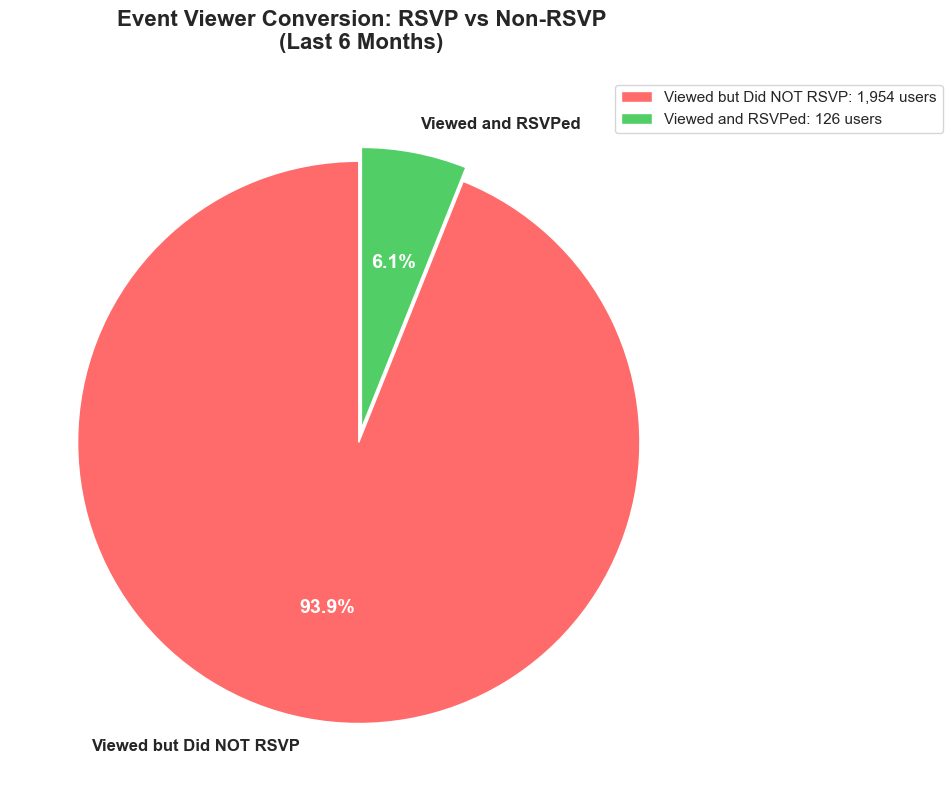

📊 Conversion Summary:
   • Non-converters: 1,954 users (93.91%)
   • Converters: 126 users (6.09%)
   • Total viewers: 2,068 users


In [29]:
import matplotlib.pyplot as plt

# Create a pie chart showing conversion breakdown
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Data for pie chart
conversion_data = {
    'Viewed but Did NOT RSVP': len(viewers_no_rsvp),
    'Viewed and RSVPed': len(bigquery_rsvp_users)
}

colors = ['#ff6b6b', '#51cf66']
explode = (0.05, 0)  # Explode the non-RSVP slice for emphasis

wedges, texts, autotexts = ax.pie(
    conversion_data.values(),
    labels=conversion_data.keys(),
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    textprops={'fontsize': 12, 'weight': 'bold'}
)

# Enhance autotext
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(14)

ax.set_title('Event Viewer Conversion: RSVP vs Non-RSVP\n(Last 6 Months)', 
             fontsize=16, weight='bold', pad=20)

# Add a legend with counts
legend_labels = [f'{label}: {value:,} users' for label, value in conversion_data.items()]
ax.legend(legend_labels, loc='upper left', bbox_to_anchor=(0.85, 1), fontsize=11)

plt.tight_layout()
plt.show()

print(f"📊 Conversion Summary:")
print(f"   • Non-converters: {len(viewers_no_rsvp):,} users (93.91%)")
print(f"   • Converters: {len(bigquery_rsvp_users):,} users (6.09%)")
print(f"   • Total viewers: {len(amplitude_viewers):,} users")